In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seysmo.models.model_class import CNN, CNNLSTMNetwork, CNNLSTMNetwork2, MLP, ParallelLSTMConv2DModel, LSTMPredictor
from seysmo.models.train_model import train, evaluate
from seysmo.models.utils import save_model, load_model, count_parameters, EarlyStopper, SignalSpeedDataset, give_data
from seysmo.visualization.plotting import plot_map
from seysmo.features.mapping import do_array_for_mapping, compute_y_pred
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import MeanAbsolutePercentageError

import mlflow

mlflow.set_tracking_uri("http://localhost:5000")

In [11]:
X_train, y_train, coord_train, X_val, y_val, coord_val, X_test, y_test, coord_test = give_data(
    '../data/processed/coord_dict.pkl', 6)

In [12]:
X_train.shape

(5523, 33, 438)

In [13]:
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))
X_train.shape

(5523, 438, 33)

In [14]:
train_dataset = SignalSpeedDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = SignalSpeedDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
linear_input_size = 438*33
linear_output_size = 10
epochs = 70
batch_size = 32
learning_rate = 0.001
patience = 5
min_delta = 30
loss_fn = nn.MSELoss()
metric_fn = MeanAbsolutePercentageError().to(device)
model0 = MLP(input_size=linear_input_size, output_size=linear_output_size).to(device)
early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate)

In [7]:
mlflow.set_experiment("/MLP_v0.1")

2024/07/28 16:10:53 INFO mlflow.tracking.fluent: Experiment with name '/MLP_v0.1' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/487852101959110837', creation_time=1722172253314, experiment_id='487852101959110837', last_update_time=1722172253314, lifecycle_stage='active', name='/MLP_v0.1', tags={}>

In [16]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        'linear_input_size': linear_input_size,
        'linear_output_size': linear_output_size,
        'patience': patience,
        'min_delta': min_delta
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model0)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train(train_dataloader, model0, loss_fn, metric_fn, optimizer, epoch=t, device=device,
              output_size=linear_output_size)
        validation_loss, validation_mape = evaluate(val_dataloader, model0, loss_fn, metric_fn, epoch=t, device=device,
                                                    output_size=linear_output_size)
        if early_stopper.early_stop(validation_loss):
            break

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model0, "model")

Epoch 1
-------------------------------
loss: 125521.289062 MAPE: 0.999929 [0 / 173]
loss: 2928.988037 MAPE: 0.132732 [100 / 173]
Eval metrics: 
MAPE: 0.12, Avg loss: 2711.523843 

Epoch 2
-------------------------------
loss: 2690.574951 MAPE: 0.126015 [0 / 173]
loss: 2669.549561 MAPE: 0.105521 [100 / 173]
Eval metrics: 
MAPE: 0.12, Avg loss: 2666.859170 

Epoch 3
-------------------------------
loss: 1791.225220 MAPE: 0.111222 [0 / 173]
loss: 1620.618164 MAPE: 0.101526 [100 / 173]
Eval metrics: 
MAPE: 0.10, Avg loss: 2125.289614 

Epoch 4
-------------------------------
loss: 1597.268799 MAPE: 0.089401 [0 / 173]
loss: 1378.381226 MAPE: 0.083634 [100 / 173]
Eval metrics: 
MAPE: 0.10, Avg loss: 2041.782003 

Epoch 5
-------------------------------
loss: 1391.848145 MAPE: 0.087162 [0 / 173]
loss: 2136.163818 MAPE: 0.099817 [100 / 173]
Eval metrics: 
MAPE: 0.10, Avg loss: 2096.993425 

Epoch 6
-------------------------------
loss: 1647.138672 MAPE: 0.102689 [0 / 173]
loss: 1353.804321 MA

2024/07/28 16:21:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/07/28 16:21:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
C:\Users\vitya\Work\seysmo\.venv\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable b

In [17]:
num_batches = len(test_dataloader)
eval_loss, eval_mape = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model0(X)
        eval_loss += loss_fn(torch.reshape(pred, (-1, 10)), torch.reshape(y, (-1, 10))).item()
        eval_mape += metric_fn(torch.reshape(pred, (-1, 10)), torch.reshape(y, (-1, 10))).item()

eval_loss /= num_batches
eval_mape /= num_batches
print(f"Test loss: {eval_loss:4f}")
print(f"Test MAPE: {eval_mape:4f}")

Test loss: 1422.894954
Test MAPE: 0.077587


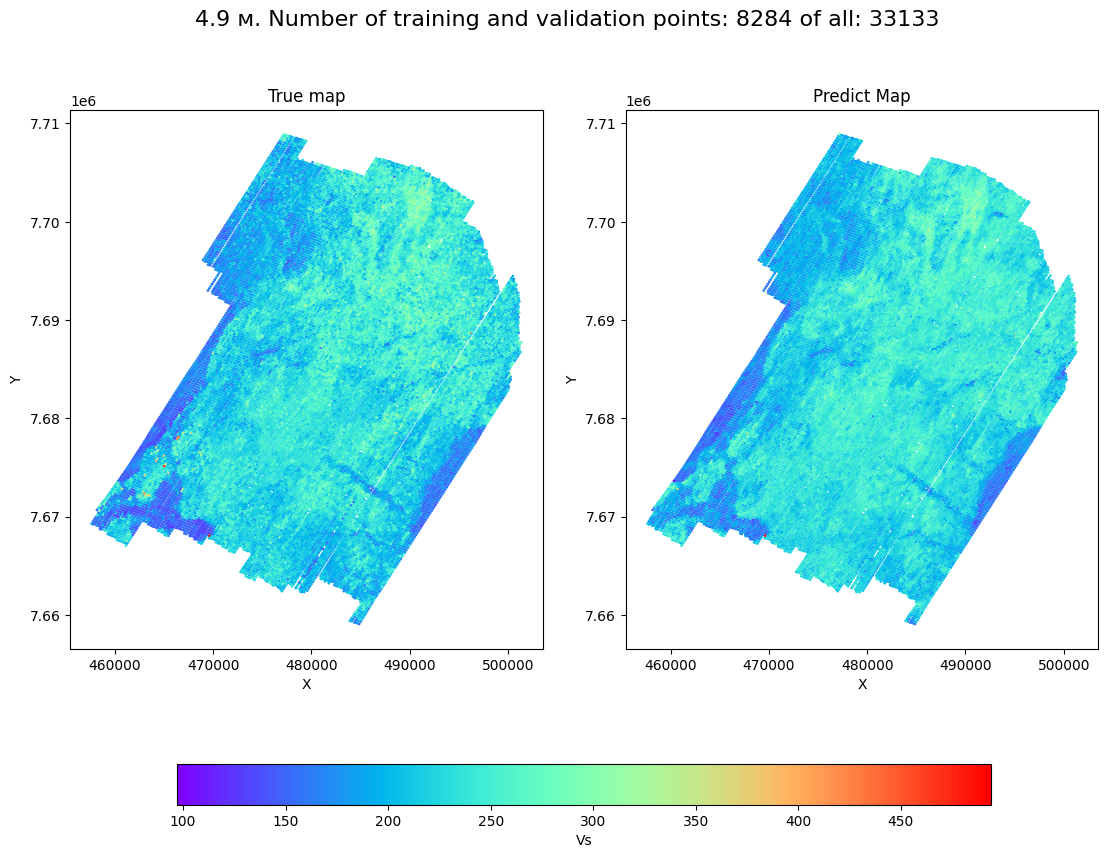

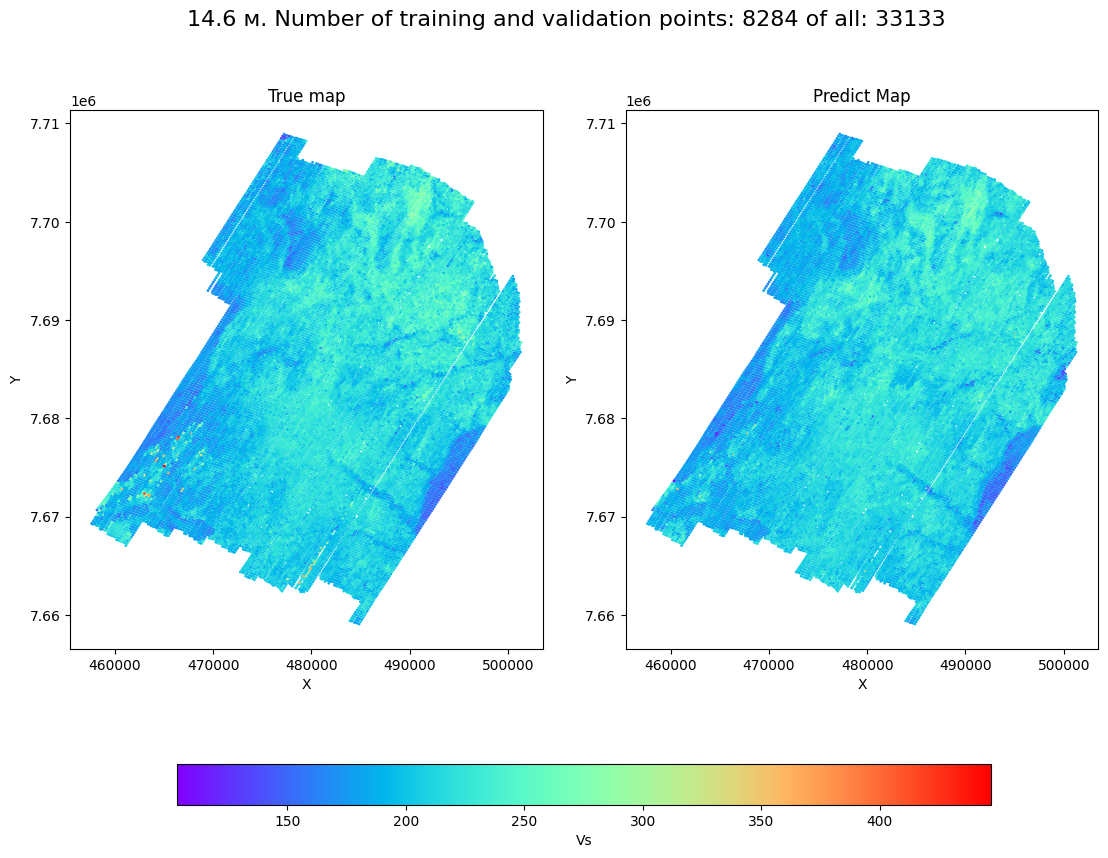

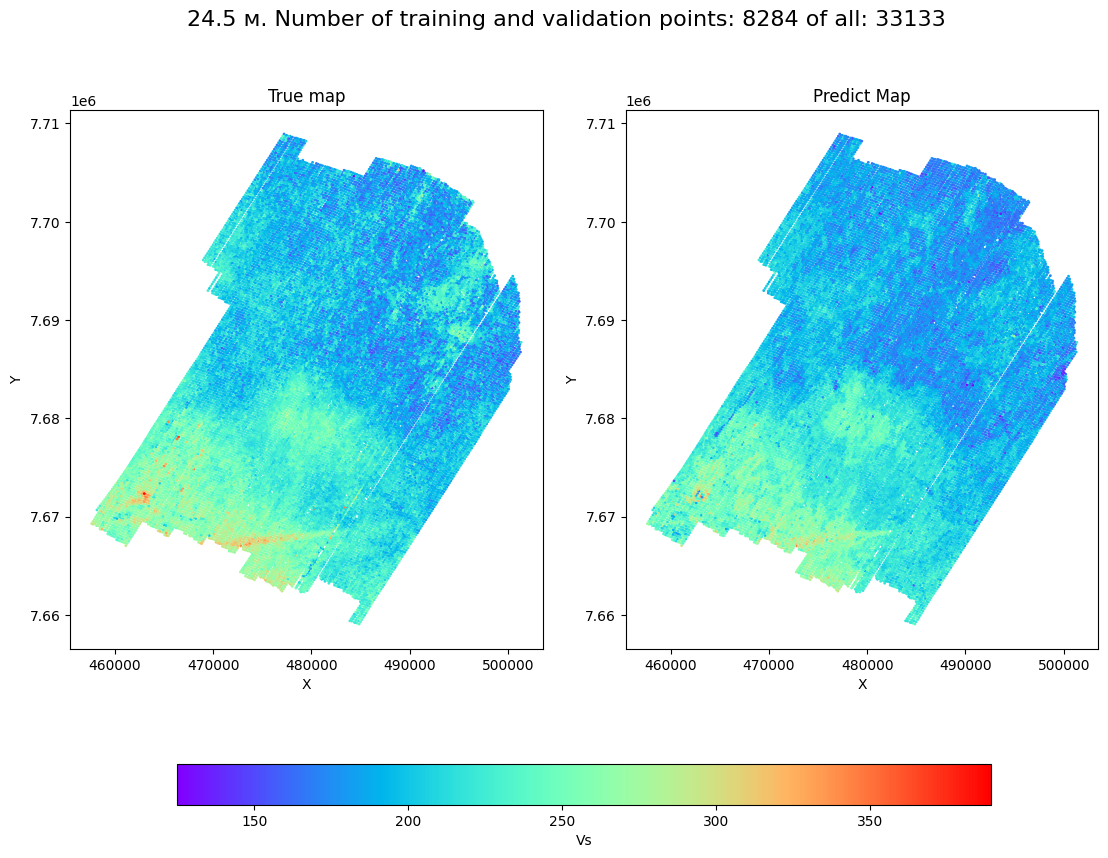

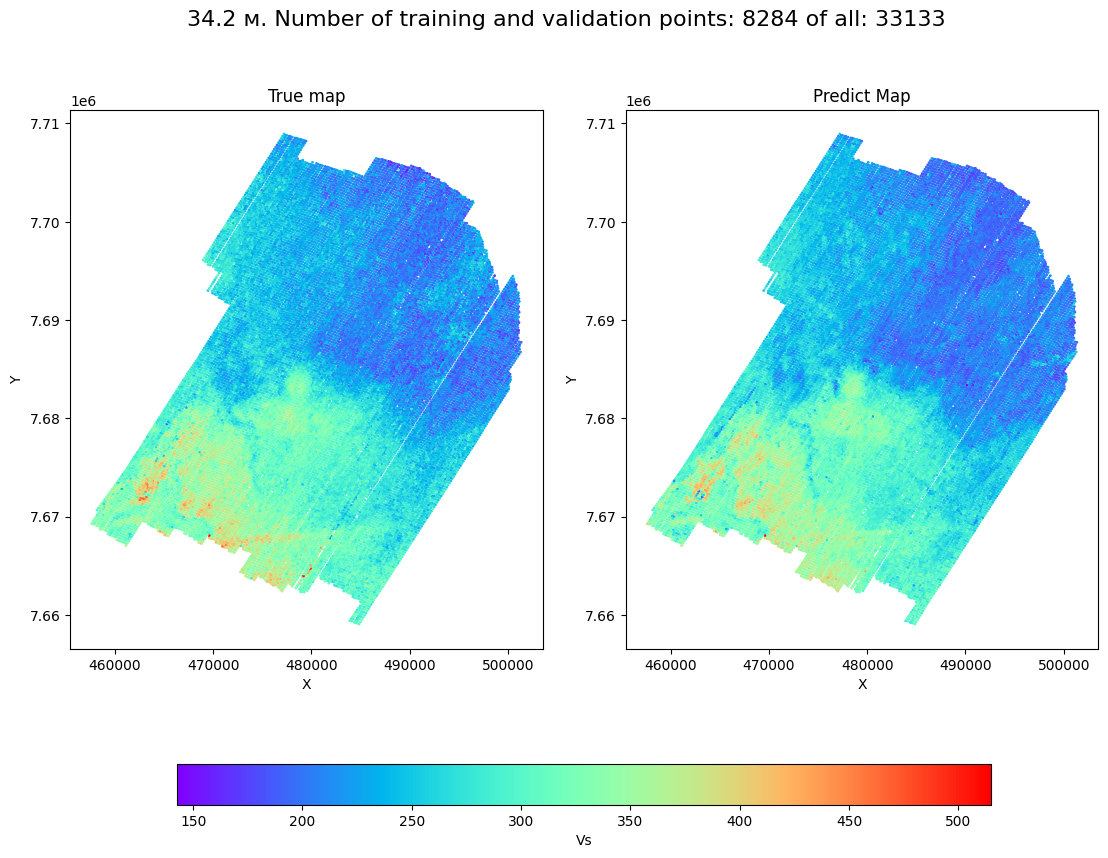

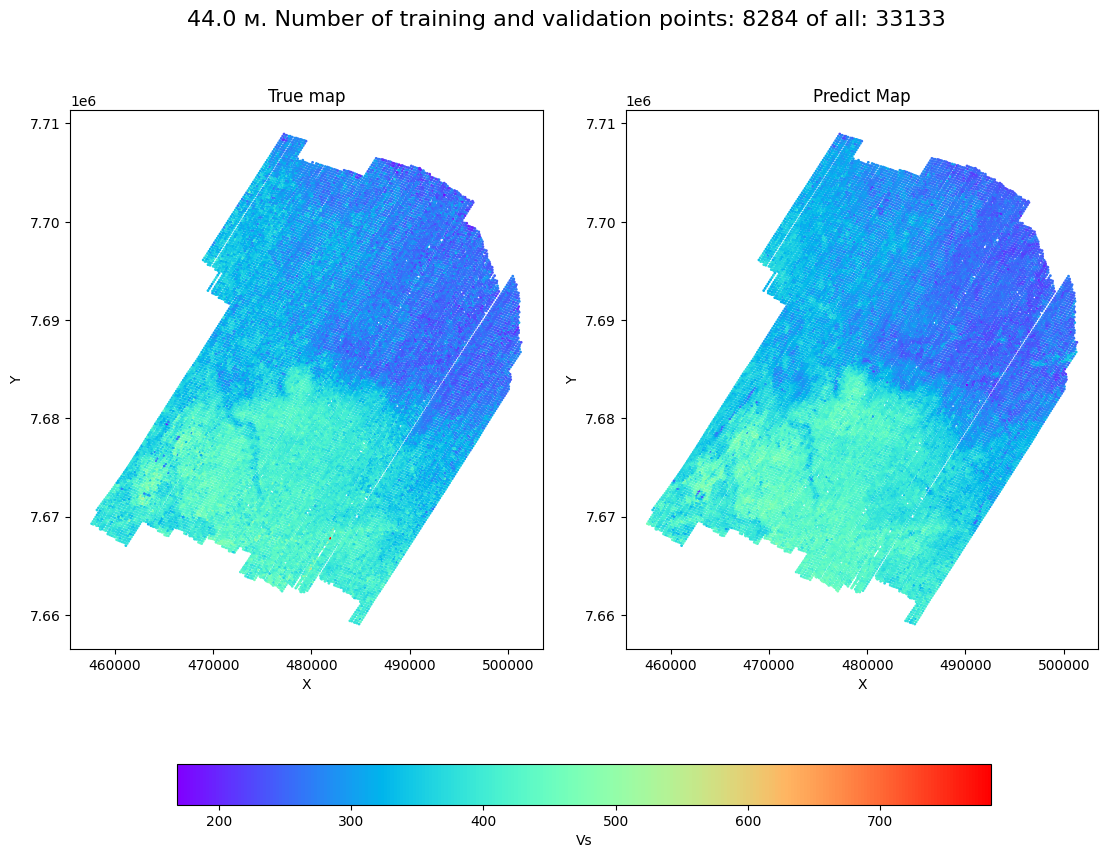

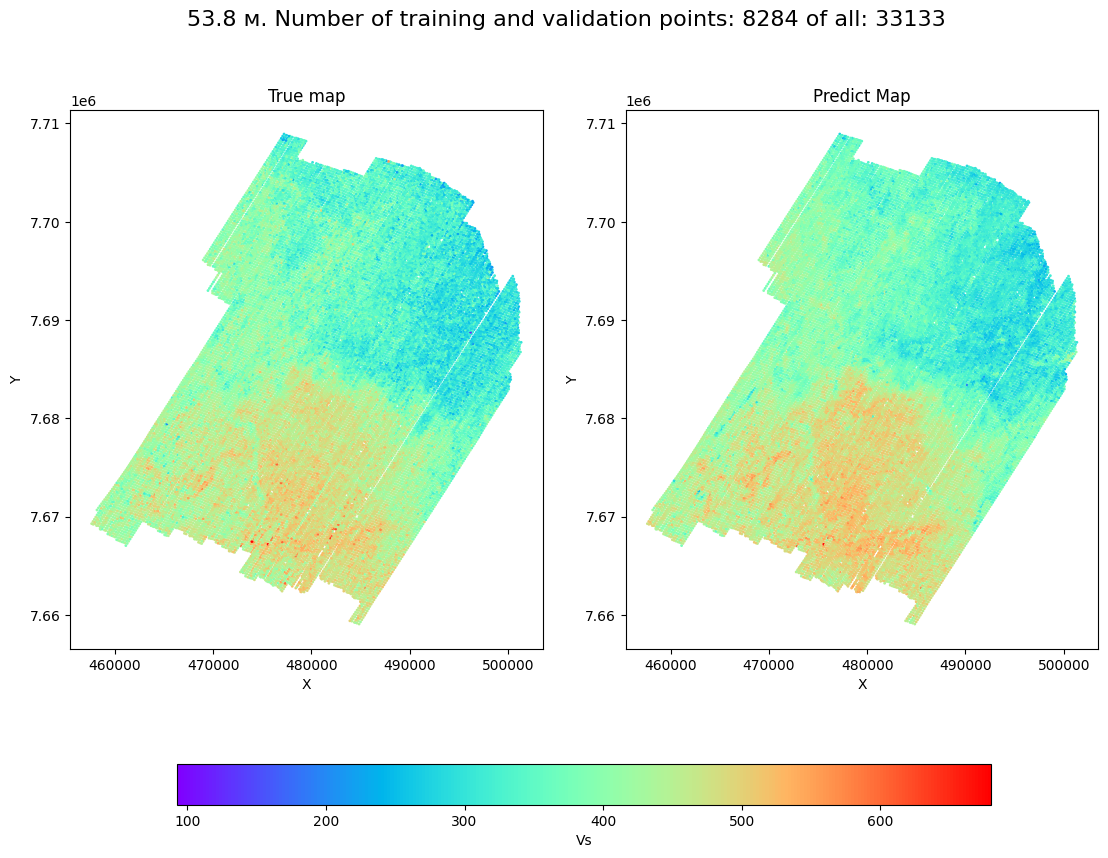

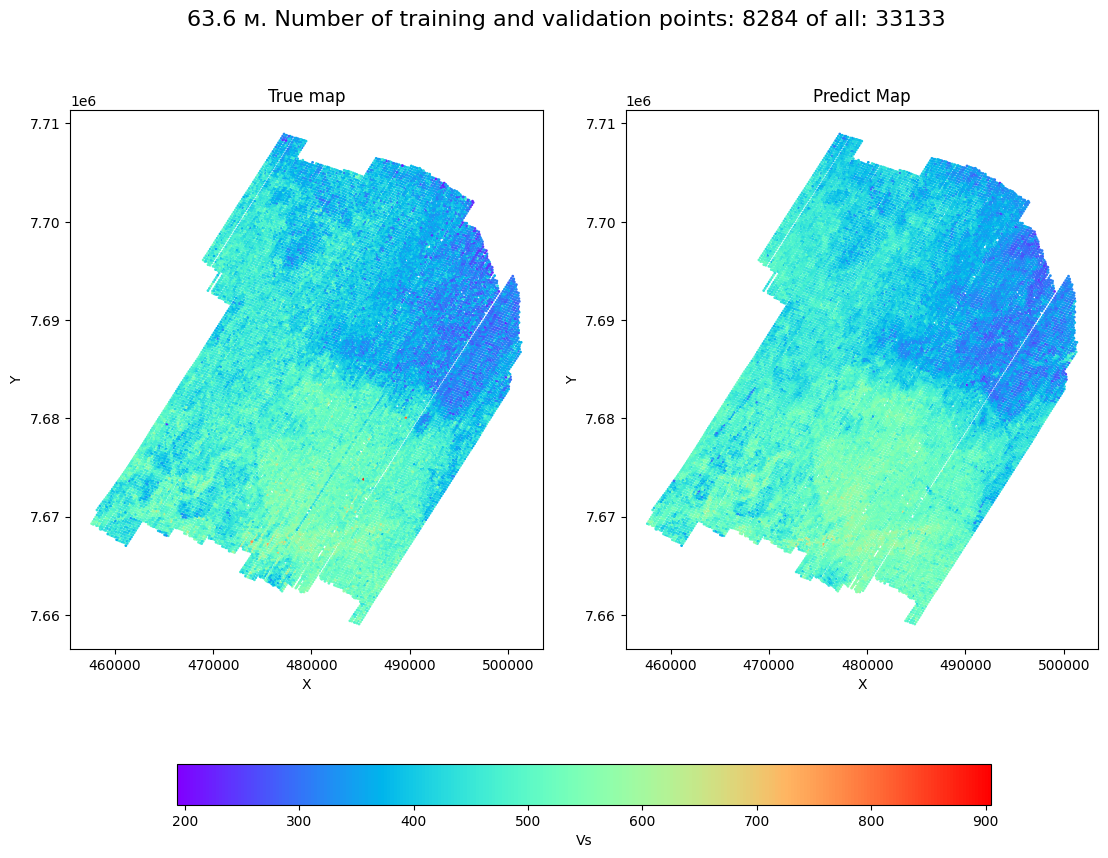

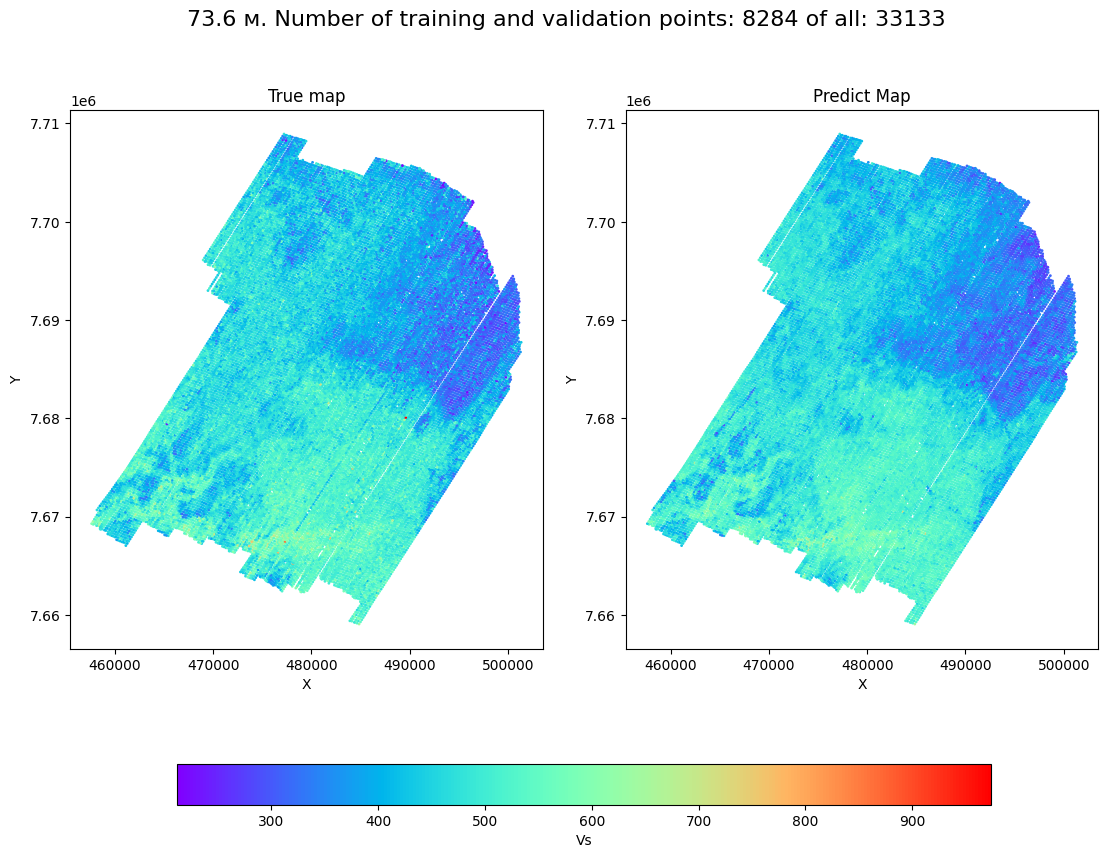

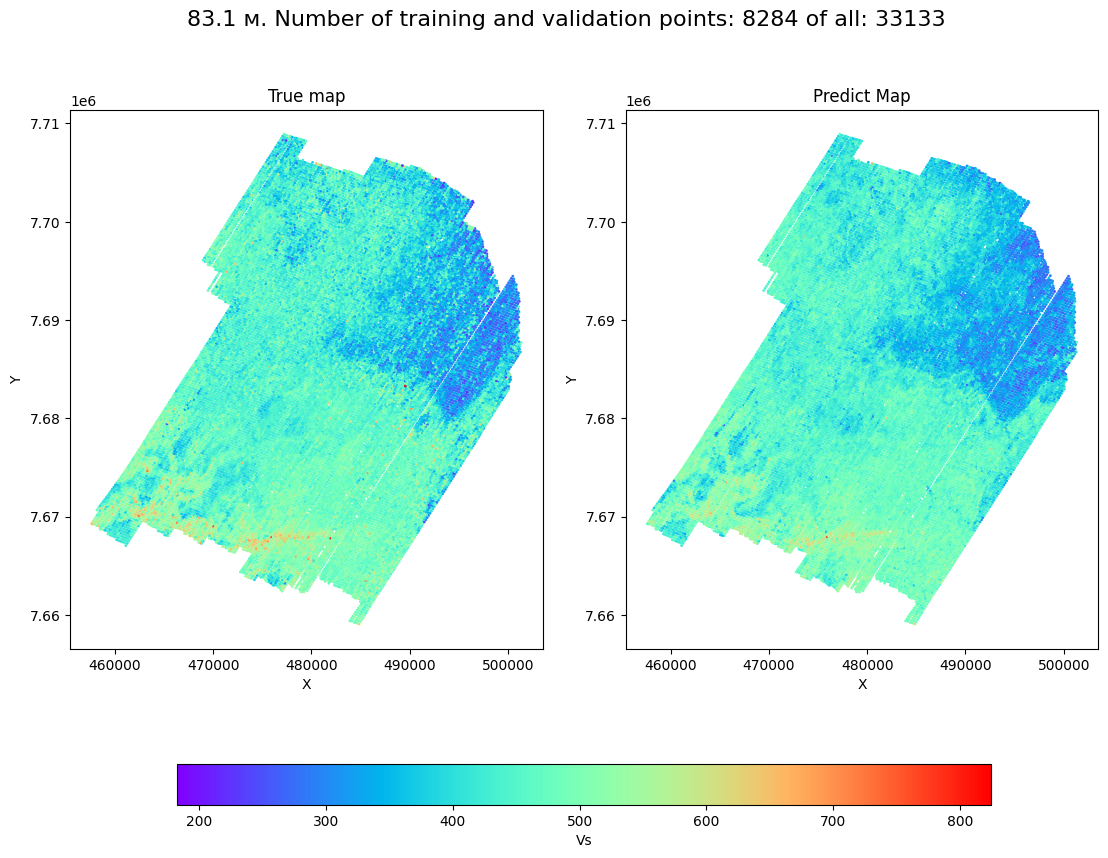

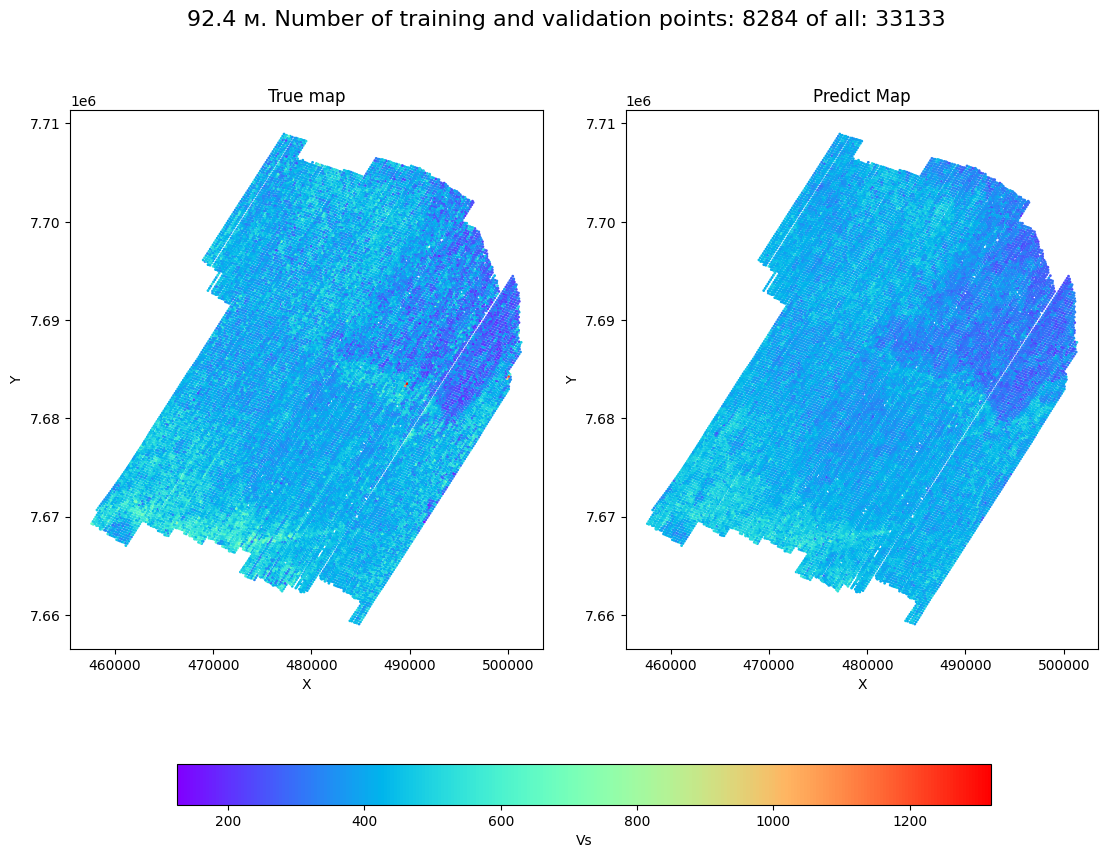

In [18]:
y_pred = None
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model0(X).to("cpu").detach().numpy()
        if y_pred is None:
            y_pred = pred
        else:
            y_pred = np.concatenate([y_pred, pred])
depth_ar = [4.9, 14.6, 24.5, 34.2, 44.0, 53.8, 63.6, 73.6, 83.1, 92.4]
for i in range(10):
    true_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, i], y_val[:, i], y_test[:, i])
    pred_slice = do_array_for_mapping(coord_train, coord_val, coord_test, y_train[:, i], y_val[:, i], y_pred[:, i])
    our_map = plot_map(true_slice, pred_slice, depth_ar[i], X_train.shape[0], X_val.shape[0], X_test.shape[0])
    our_map.savefig(f"../reports/figures/maps/{round(depth_ar[i])}map.png")
    plt.show(our_map)